In [9]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False  # if autocomplete is not working

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import io
from collections import Counter
from sklearn.ensemble import GradientBoostingRegressor as model
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

In [11]:
levels_df = pd.read_csv('processed.csv').dropna()
levels_df['date'] = pd.to_datetime(levels_df['date'])

In [12]:
forecast_df = pd.read_csv('weather_forecast.csv',sep=';')
forecast_df['precipsnow'] = forecast_df['preciptype'].fillna('').str.contains('snow').astype(int)
forecast_df['precipsrain'] = forecast_df['preciptype'].fillna('').str.contains('rain').astype(int)
forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])

/tmp/ipykernel_43942/195486111.py:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  forecast_df = pd.read_csv('weather_forecast.csv',sep=';')


In [13]:
df = pd.merge(
    forecast_df, levels_df, left_on='datetime', right_on='date'
).sort_values('date')

In [14]:
offsets = [1, 2, 3, 7]
train_data = []
test_data_by_offset = {o: [] for o in offsets}
dates = []

past_days = 3
for start_day in range(past_days, len(df) - max(offsets)):
    x = df.iloc[start_day - past_days:start_day]
    train_data.append(
        np.concatenate([
            # all levels
            x[[c for c in levels_df.columns if c != 'date']].values.flatten(),
            # sum of past precip 
            x[[c for c in levels_df.columns if 'prec-' in c]].sum(axis=0).values.flatten(),
            # sum of precip forecast
            df.iloc[start_day:(start_day+past_days)][[
                'precip', 'precipprob', 'precipcover', 'precipsnow', 'precipsrain'
            ]].values.sum(axis=0),
        ])
    )
    dates.append(df.iloc[start_day]['date'])
    for o in offsets:
        yy = df.iloc[start_day:start_day+o]['level-12'].max()
        assert np.isfinite(yy)
        test_data_by_offset[o].append(yy)

train_data = np.array(train_data)
test_data_by_offset = {k: np.array(v).reshape((-1, 1)) for k, v in test_data_by_offset.items()}

In [15]:
train_data = np.array(train_data)
test_data_by_offset = {k: np.array(v) for k, v in test_data_by_offset.items()}

In [16]:
train_test_cut = -359

# TPOT

In [17]:
X_train = train_data[:train_test_cut].astype("float32")
o = offsets[0]
y_train = test_data_by_offset[o][:train_test_cut].astype("float32")

X_test = train_data[train_test_cut:].astype("float32")
y_test = test_data_by_offset[o][train_test_cut:].astype("float32")

In [20]:
from tpot import TPOTRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [21]:
SEED = 12

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

In [22]:
# TPOT setup
GENERATIONS = 5
POP_SIZE = 100  # 100
CV = TimeSeriesSplit(3)

tpot = TPOTRegressor(
    generations=GENERATIONS,
    population_size=POP_SIZE,
    random_state=SEED,
    # config_dict="TPOT cuML",
    n_jobs=-1,
    cv=CV,
    verbosity=2,
    max_time_mins = 30,
    max_eval_time_mins=3,
)

tpot.fit(X_train, y_train.ravel())

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -345.13303629557294


TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LassoLarsCV(input_matrix, normalize=True)

Best pipeline: LassoLarsCV(input_matrix, normalize=True)


TPOTRegressor(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
              generations=5, max_eval_time_mins=3, max_time_mins=30, n_jobs=-1,
              random_state=12, verbosity=2)

In [23]:
preds = tpot.predict(X_test)
((y_test-preds)**2).mean()

6412.2686

In [24]:
(abs(y_test-preds)).mean()

57.677917

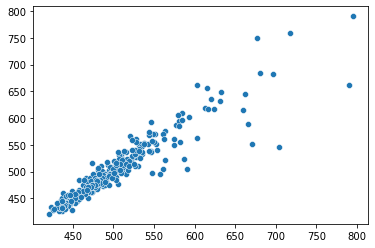

In [23]:
sns.scatterplot(
    x=y_test,
    y=preds,
)

In [24]:
tpot.export('tpot_exported_pipeline.py')